In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import listdir
from os.path import isfile
import json
from pathlib import Path
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from crowdkit.aggregation import MMSR
import pandas as pd

In [3]:
data_dir = Path("data")
grading_data_dir = data_dir / "to-grade"

## Collect grades

In [4]:
conala_model_list = ['grade-tranx-annot', 'grade-snippet', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-baseline', 'grade-codex']
hs_model_list = ["grade-gcnn", "grade-nl2code"]

In [5]:
def collect_grades(dataset_name, models_list):
    dataset_dir = grading_data_dir / dataset_name
    grade_files = [
        f
        for f in listdir(dataset_dir)
        if isfile(dataset_dir / f) and f.startswith("grader")
    ]

    all_grades = json.load(open(dataset_dir / f"{dataset_name}.json"))

    for file_name in grade_files:
        assessor_name = file_name.split('.')[0]
        grades = json.load(open(dataset_dir / file_name))

        for i, item in enumerate(grades):
            for model in models_list:
                current_grade = item.get(model)
                if current_grade is not None:
                    if all_grades[i].get(model) is None:
                        all_grades[i][model] = dict()
                    if current_grade > -1:
                        all_grades[i][model][assessor_name] = current_grade

    with open(dataset_dir / f"{dataset_name}-human-grades.json", 'w') as o:
        json.dump(all_grades, o)

In [6]:
collect_grades("conala", conala_model_list)

In [7]:
collect_grades("hs", hs_model_list)

In [8]:
def myround(a, b): # for averaging grades
    if random.randint(1,2) == 1:
        return int(round((a+b-0.001)/2,0))
    else:
        return int(round((a+b+0.001)/2,0))

In [9]:
def clean_grades(dataset_name, models_list):
    dataset_dir = grading_data_dir / dataset_name
    grades = json.load(open(dataset_dir / f"{dataset_name}-human-grades.json"))

    to_remove = []
    for i, d1 in enumerate(grades):

        if isinstance(d1['snippet'], str):
            d1['snippet'] = [d1['snippet']]

        for j, d2 in enumerate(grades):
            if i < j and d1['intent'] == d2['intent']:
                to_remove.append(j)
                d1['snippet'].append(d2['snippet'])
                for model_grade in models_list:
                    for key in d2[model_grade]:
                        if d1[model_grade].get(key) is None:
                            d1[model_grade][key] = d2[model_grade][key]
                        else:
                            d1[model_grade][key] = myround(d1[model_grade][key], d2[model_grade][key])

    clean_grades = [grades[j] for j in range(len(grades)) if j not in to_remove]

    with open(dataset_dir / f"{dataset_name}-human-grades.json", 'w') as o:
        json.dump(clean_grades, o)

    return clean_grades

In [10]:
conala_grades = clean_grades("conala", conala_model_list)

In [11]:
len(conala_grades)

472

In [12]:
cnt = Counter()

for item in conala_grades:
    for grade in conala_model_list:
        if grade != "grade-snippet":
            cnt[len(item[grade])] += 1

print(cnt)

Counter({4: 998, 5: 502, 3: 402, 6: 364, 7: 57, 8: 27, 9: 5, 10: 5})


In [13]:
total_labels = 0
for (key, value) in cnt.items():
    total_labels += key * value

print(total_labels / (len(conala_model_list) - 1) / len(conala_grades))

4.492372881355933


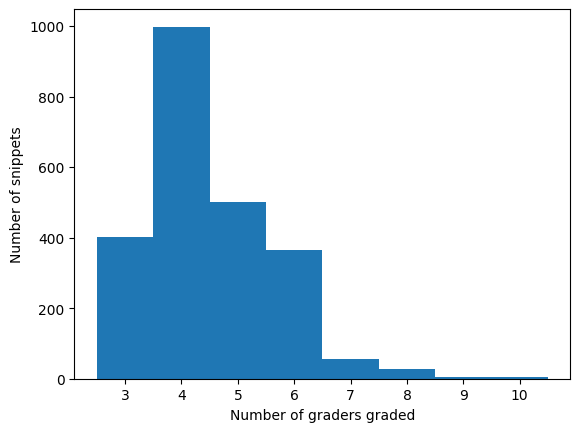

In [14]:
labels, values = zip(*sorted(cnt.items()))

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes , labels)
plt.xlabel('Number of graders graded')
plt.ylabel('Number of snippets')
plt.savefig("data/plots/graders-distrib.pdf")
plt.show()

## Aggregate Conala grades

In [15]:
conala_grades = json.load(open(grading_data_dir / "conala" / "conala-human-grades.json"))

In [16]:
models = ['grade-baseline', 'grade-tranx-annot', 'grade-best-tranx', 'grade-best-tranx-rerank', 'grade-codex']
row_list = []
for i, sample in enumerate(conala_grades):
    for j, model in enumerate(models):
        task_number = i + j * len(conala_grades)
        for grader, grade in sample[model].items():
            a = {
                "worker": grader,
                "task": task_number,
                "label": grade
            }
            row_list.append(a)

grades_df = pd.DataFrame(row_list, columns=["worker", "task", "label"])

In [17]:
agg_mmsr = MMSR().fit_predict(grades_df)
golden_truth = agg_mmsr.tolist()

for i, grade in enumerate(golden_truth):
    quest = i % len(conala_grades)
    model = i // len(conala_grades)
    conala_grades[quest][models[model]] = grade

In [18]:
json.dump(conala_grades, open(grading_data_dir / "conala" / "conala-aggregated-grades.json", "w"))

## Aggregate Hearthstone grades

In [19]:
hs_grades = json.load(open(grading_data_dir / "hs" / "hs-human-grades.json"))

In [20]:
for item in hs_grades:
    item['snippet'] = [item['snippet']]
    item['nl2code'] = item['nl2code'].rstrip()

In [21]:
models = ['grade-gcnn', 'grade-nl2code']
row_list = []
for i, sample in enumerate(hs_grades):
    for j, model in enumerate(models):
        task_number = i + j * len(hs_grades)
        for grader, grade in sample[model].items():
            a = {
                "worker": grader,
                "task": task_number,
                "label": grade
            }
            row_list.append(a)

grades_df = pd.DataFrame(row_list, columns=["worker", "task", "label"])

In [22]:
agg_mmsr = MMSR().fit_predict(grades_df)
golden_truth = agg_mmsr.tolist()

for i, grade in enumerate(golden_truth):
    quest = i % len(hs_grades)
    model = i // len(hs_grades)
    hs_grades[quest][models[model]] = grade

In [23]:
json.dump(hs_grades, open(grading_data_dir / "hs" / "hs-aggregated-grades.json", "w"))